# Model fitting - Retest Sample

## Analysis overview

#### Discovery sample

1. Model fitting: [`Model fitting - Discovery.ipynb`](<../../notebooks/discovery/Model fitting - Discovery.ipynb>)
2. Confidence analysis: [`Confidence analysis - Discovery.ipynb`](<../../notebooks/discovery/Confidence analysis - Discovery.ipynb>)
3. Transdiagnostic factor estimation: [`Transdiagnostic factors - Discovery.ipynb`](<../../notebooks/discovery/Transdiagnostic factors - Discovery.ipynb>)
4. Symptom-behaviour analyses: [`Symptom analyses - Discovery.ipynb`](<../../notebooks/discovery/Symptom analyses - Discovery.ipynb>)

#### Replication sample

1. Model fitting: [`Model fitting - Replication.ipynb`](<../../notebooks/replication/Model fitting - Replication.ipynb>)
2. Confidence analysis: [`Confidence analysis - Replication.ipynb`](<../../notebooks/replication/Confidence analysis - Replication.ipynb>)
3. Two-step task analysis: [`Two-step modelling - Replication.ipynb`](<../../notebooks/replication/Two-step modelling - Replication.ipynb>)
4. Transdiagnostic factor estimation: [`Transdiagnostic factors - Replication.ipynb`](<../../notebooks/replication/Transdiagnostic factors - Replication.ipynb>)
5. Symptom-behaviour analyses: [`Symptom analyses - Replication.ipynb`](<../../notebooks/replication/Symptom analyses - Replication.ipynb>)

#### Test-retest sample

1. **⭐ Model-fitting: [`Model fitting - Retest.ipynb`](<../../notebooks/retest/Model fitting - Retest.ipynb>)** ⭐
2. Two-step modelling: [`Two-step modelling - Retest.ipynb`](<../../notebooks/retest/Two-step modelling - Retest.ipynb>)
3. Test-retest reliability analyses: [`Test-retest - Retest.ipynb`](<../../notebooks/retest/Test-retest - Retest.ipynb>)

#### Follow-up sample

1. Model fitting: [`Model fitting - Follow up.ipynb`](<../../notebooks/follow-up/Model fitting - Follow up.ipynb>)
2. Transdiagnostic factor estimation: [`Transdiagnostic factors - Follow up.ipynb`](<../../notebooks/follow-up/Transdiagnostic factors - Follow up.ipynb>)
3. Test-retest reliability analyses: [`Test-retest - Follow up.ipynb`](<../../notebooks/follow-up/Test-retest - Follow up.ipynb>)
4. Longitudinal analyses: [`Longitudinal analyses - Follow up.ipynb`](<../../notebooks/follow-up/Longitudinal analyses - Follow up.ipynb>)

#### Follow-up sample (1 year)

1. Model fitting: [`Model fitting - Follow up 1yr.ipynb`](<../../notebooks/follow-up-1yr/Model fitting - Follow up 1yr.ipynb>)
2. Transdiagnostic factor estimation: [`Transdiagnostic factors - Follow up 1yr.ipynb`](<../../notebooks/follow-up-1yr/Transdiagnostic factors - Follow up 1yr.ipynb>)
3. Test-retest reliability analyses: [`Test-retest - Follow up 1yr.ipynb`](<../../notebooks/follow-up-1yr/Test-retest - Follow up 1yr.ipynb>)
4. Longitudinal analyses: [`Longitudinal analyses -  Follow up 1yr.ipynb`](<../../notebooks/follow-up-1yr/Longitudinal analyses - Follow up 1yr.ipynb>)

## Notebook overview

This notebook performs model fitting using simulation-based inference with pre-trained models.

In [1]:
import os

os.environ["JAX_PLATFORMS"] = "cpu"

import dill
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from behavioural_modelling.learning.beta_models import beta_mean_var
from model_fit_tools.plotting import *
from model_fit_tools.plotting import plot_waic
from scipy.stats import pearsonr
from simulation_based_inference.npe import NPEModel

from transition_uncertainty.modelling_utils import (
    calculate_waic,
    find_trained_models,
    load_task_spec,
    map_sampled_params,
    repeat_for_all_subjects,
    simulate_from_mean_params,
    transform_to_bounded,
)

torch.set_num_threads(1)  # things are slow with multiple cores
torch.set_num_interop_threads(1)  # things are slow with multiple cores
from transition_uncertainty.style import set_style
from transition_uncertainty.utils import check_directories

# Raise an error if we're not in the root directory by checking if the data folder exists
check_directories()

# Set plotting style
set_style("style.mplstyle")

# Report whether we're using GPU or CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

/scratch/users/user/miniconda3/envs/tu_test_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Font Heebo already available in Matplotlib.
Matplotlib style set to: style.mplstyle with font Heebo
Using device: cpu


## Load task specification

Here we load in information about the task (e.g., rewards, transition probabilities, etc.).


In [2]:
# Load task specification
(
    second_stage_states,
    second_stage_state_probs,
    rewards,
    reward_probs,
    available_side,
) = load_task_spec("data/task_spec")

# Get trials where MB was blocked
MB_blocked = (reward_probs == 2)[0, :, 0]

/users/user/.local/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


## Extract choices from response data

Next we need to load in the response data and extract the choices made by the participant.


In [3]:
choices = []

data = pd.read_csv("data/retest/transition-task/cannonball_task_data.csv")

for sub in data["subjectID"].unique():
    choices.append(data[data["subjectID"] == sub].response.values - 1)

# Stack choices
choices = np.stack(choices)[:, None, :]

# Remove confidence trials as these are not relevant for model fitting
choices_without_confidence = choices[:, :, available_side[0, :] == -1]

# Get the number of subjects
N_SUBJECTS = choices.shape[0]

print(f"Number of subjects: {N_SUBJECTS}")

Number of subjects: 85


## Model fitting using SBI

Parameters are estimated using simulation-based inference. We use the models that were pre-trained using the scripts provided in the `./scripts` directory.

Here we only fit the pure model-based model as this was the winning model at the initial time point.


### Load in trained models

We don't care about the combination models here as they didn't fit well, so we only load the best-fitting model (pure model-based), along with the pure model-free model to provide measures of model-basedness.


In [4]:
# Specify models
models = ["mf_only", "mb_only"]

# Get the trained models
trained_models = find_trained_models(models, "models")

### Sample from the posterior

This seems to work slowly if you don't have a lot of memory...


In [5]:
# Loop through models and sample parameters
sampled_params_dict = {}

for model in models:
    print("Sampling parameters for model: {}".format(model))
    sampled_params_dict[model] = trained_models[model].sample(
        choices_without_confidence, n_samples=1000
    )

# Create directory if it doesn't exist
if not os.path.exists("results/retest/transition-task_model-fit"):
    os.makedirs("results/retest/transition-task_model-fit")

# Save the sampled parameters
with open(
    os.path.join(
        "results/retest/transition-task_model-fit", "sampled_params_dict.pkl"
    ),
    "wb",
) as f:
    dill.dump(sampled_params_dict, f)

Sampling parameters for model: mf_only


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 85/85 [00:02<00:00, 28.70it/s]


Sampling parameters for model: mb_only


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 85/85 [00:02<00:00, 29.04it/s]


## Model fit

Next we estimate the [WAIC](https://arxiv.org/abs/1507.04544) for each model. This is a measure of model fit that penalises models with more parameters. We use the [arviz](https://arviz-devs.github.io/arviz/) package to calculate the WAIC, both across all subjects and for each subject individually.


In [6]:
# Initialise dictionaries
waic_dict = {}
subject_waic_dict = {}

# Loop through models and calculate WAIC
for model in models:
    print("Calculating WAIC for model: {}".format(model))

    # Create a template array to fill in with estimated parameters Different
    # models have different numbers of parameters, but the WAIC function
    # requires that all models have the same number of parameters. This
    # template array is used to fill in the estimated parameters for each
    # model.
    sampled_param_template = np.zeros(
        (
            sampled_params_dict[model].shape[0],
            sampled_params_dict[model].shape[1],
            6,
        )
    )

    # Map sampled parameters to the template array
    sampled_params_mapped = map_sampled_params(
        model, sampled_params_dict[model], sampled_param_template
    )

    # Transform back to bounded
    sampled_params_mapped[:, :, 4] = transform_to_bounded(
        sampled_params_mapped[:, :, 4], 0.1, 0.9
    )
    sampled_params_mapped[:, :, 5] = transform_to_bounded(
        sampled_params_mapped[:, :, 5], 0.01, 0.2
    )

    # Get dataset and waic
    ds, waic_dict[model] = calculate_waic(
        sampled_params_mapped,
        second_stage_states,
        rewards,
        reward_probs,
        available_side,
        choices,
        pointwise=True,
    )

    # Get subject-wise WAIC
    subject_waic_dict[model] = waic_dict[model].waic_i.sum(axis=-1)

########################
# Convert to dataframe #
########################

# Initialise dataframe
waic_df = {"model": [], "waic": [], "se": []}

# Loop through models and append values to dataframe
for model, waic in waic_dict.items():
    waic_df["model"].append(model)
    waic_df["waic"].append(waic.elpd_waic)
    waic_df["se"].append(waic.se)

# Convert to dataframe
waic_df = pd.DataFrame(waic_df)
waic_df.head()

# Get unique subject IDs
unique_subject_IDs = pd.Series(data["subjectID"].unique())

# Convert your original dictionary to a DataFrame
subject_waic_df = pd.DataFrame(subject_waic_dict).stack().reset_index()

# Assign proper column names
subject_waic_df.columns = ["subject", "model", "waic"]

# Ensure that 'subject' column has corresponding subject IDs
subject_waic_df["subject"] = unique_subject_IDs.loc[
    subject_waic_df["subject"]
].values

# Save dataframes
waic_df.to_csv("results/retest/transition-task_model-fit/group_waic.csv")
subject_waic_df.to_csv(
    "results/retest/transition-task_model-fit/subject_waic.csv"
)

Calculating WAIC for model: mf_only
Calculating WAIC for model: mb_only


### Plot estimated parameter distributions


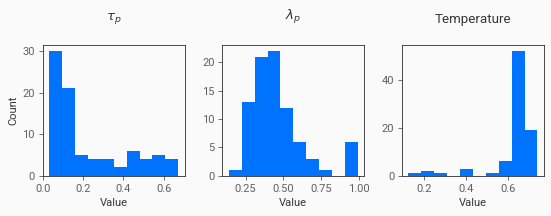

In [7]:
param_names = [
    "$\\tau_p$",
    "$\\lambda_p$",
    "Temperature",
]

plot_parameter_dists(sampled_params_dict["mb_only"], param_names=param_names)

## Add parameter values to a dataframe


In [8]:
best_model = "mb_only"

best_model_sampled_params = sampled_params_dict[best_model].copy()

# Fill in the template array
sampled_param_template = np.zeros(
    (best_model_sampled_params.shape[0], best_model_sampled_params.shape[1], 6)
)

# Map sampled parameters to the template array
best_model_sampled_params = map_sampled_params(
    best_model, best_model_sampled_params, sampled_param_template
).mean(axis=0)

param_df = {
    "subjectID": data["subjectID"].unique(),
    "tau_value": best_model_sampled_params[:, 0],
    "tau_prob": best_model_sampled_params[:, 1],
    "decay_value": best_model_sampled_params[:, 2],
    "decay_prob": best_model_sampled_params[:, 3],
    "W": best_model_sampled_params[:, 4],
    "temperature": best_model_sampled_params[:, 5],
    "MB_MF_WAIC_diff": (
        subject_waic_dict["mb_only"] - subject_waic_dict["mf_only"]
    ).data,
}

param_df = pd.DataFrame(param_df)

param_df.head()

,subjectID,tau_value,tau_prob,decay_value,decay_prob,W,temperature,MB_MF_WAIC_diff
0,sub-008,0.0,0.074443,0.0,0.393051,1.0,0.650153,1.512692
1,sub-024,0.0,0.096424,0.0,0.267478,1.0,0.666448,0.236178
2,sub-069,0.0,0.144345,0.0,0.614619,1.0,0.697329,0.069525
3,sub-100,0.0,0.473795,0.0,0.679079,1.0,0.657942,14.284002
4,sub-1032,0.0,0.059271,0.0,0.468900,1.0,0.632648,-1.138342


## Simulate data using estimated parameters

This code simulates data from the winning model using the estimated parameters.

This creates two `.csv` files:

-   `data/task/model_fit_results/param_df.csv`: This contains the estimated parameter values for each subject, alongside the average mean and variance of transition estimates across the task for each subject.
-   `data/task/model_fit_results/cannonball_task_data_with_model_values.csv`: This augments the raw task data for each subject with trialwise estimates of the mean and variance of transition estiamtes across the task.


In [9]:
# Simulate data from the model using the mean parameter values
_, transition_estimates, combined_dists = simulate_from_mean_params(
    best_model_sampled_params,
    second_stage_states,
    rewards,
    reward_probs,
    available_side,
)

# Get average transition mean and var across the task
transition_mean, transition_var = beta_mean_var(transition_estimates)
param_df["transition_mean"] = transition_mean.squeeze().mean(axis=1)
param_df["transition_var"] = transition_var.squeeze().mean(axis=1)

# Get average combined mean and var across the task
combined_mean, combined_var = beta_mean_var(combined_dists)
param_df["combined_mean"] = combined_mean.squeeze().mean(axis=-1).mean(axis=-1)
param_df["combined_var"] = combined_var.squeeze().mean(axis=-1).mean(axis=-1)

# Save
param_df.to_csv(
    "results/retest/transition-task_model-fit/param_df.csv", index=False
)

# Get transition mean and var at each trial
transition_mean = transition_mean.flatten()
transition_var = transition_var.flatten()

# Add mean and var to data
data["transition_mean"] = transition_mean
data["transition_var"] = transition_var

# Save
data.to_csv(
    "results/retest/transition-task_model-fit/cannonball_task_data_with_model_values.csv",
    index=False,
)